## Распознавание эмоций по тексту

In [4]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences

from wordcloud import WordCloud

import re
from pymystem3 import Mystem

import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split

## Загрузка датасета

In [5]:
full_data_path = fr"C:\projects\Python\ML\DataBases\text_emotions\Text_Emotion.csv"

In [6]:
full_df = pd.read_csv(full_data_path)
full_df

,text,emotion
0,carefully word blog posts amount criticism hea...,☹️
1,cannot remember little mermaid feeling carefre...,🙂
2,not feeling super well turns cold knocked next...,🙂
3,feel honored part group amazing talents,🙂
4,think helping also began feel pretty lonely lo...,☹️
...,...,...
282817,feel honored motivated share world life changi...,🙂
282818,feel like gloaty really delighted,🙂
282819,feel little energetic one day next several day...,🙂
282820,feel work experience fell although fantastic o...,🙂


In [7]:
full_df.emotion[full_df.emotion == '☹️'] = 0
full_df.emotion[full_df.emotion == '🙂'] = 1
full_df

,text,emotion
0,carefully word blog posts amount criticism hea...,0
1,cannot remember little mermaid feeling carefre...,1
2,not feeling super well turns cold knocked next...,1
3,feel honored part group amazing talents,1
4,think helping also began feel pretty lonely lo...,0
...,...,...
282817,feel honored motivated share world life changi...,1
282818,feel like gloaty really delighted,1
282819,feel little energetic one day next several day...,1
282820,feel work experience fell although fantastic o...,1


In [35]:
full_df.emotion = full_df.emotion.astype(int)

## Предобработка текстовых данных

### Первичная обработка

In [247]:
def remove_punctuation(text):
    return "".join([ch if ch not in string.punctuation else ' ' for ch in text])

def remove_numbers(text):
    return ''.join([i if not i.isdigit() else ' ' for i in text])

def remove_multiple_spaces(text):
  """удаление специальных символов"""
  return re.sub(r'\s+', ' ', text, flags=re.I)

In [248]:
prep_text = [remove_multiple_spaces(remove_numbers(remove_punctuation(t.lower()))) for t in tqdm(full_df.text)]

100%|██████████| 282822/282822 [00:02<00:00, 137906.14it/s]


In [249]:
full_df['prep_text'] = prep_text

### Удаление стоп слов + стемминг

In [250]:
stemmer = SnowballStemmer('english')

In [251]:
english_stopwords = stopwords.words("english")
english_stopwords.extend(['…', '«', '»', '...'])

In [252]:
stemmed_texts = []
for text in tqdm(full_df.prep_text):
    tokens = word_tokenize(text)    
    stemmed_tokens = [stemmer.stem(token) for token in tokens if token not in english_stopwords]
    text = " ".join(stemmed_tokens)
    stemmed_texts.append(text)

100%|██████████| 282822/282822 [00:31<00:00, 9030.38it/s]


In [253]:
full_df['stem_text'] = stemmed_texts

### Лемматизация (гипотеза: модель хорошо обучится без лемматизации)

In [254]:
'''mystem = Mystem()

lemm_texts = []
for text in tqdm(full_df.stem_text):
    try:
        text_lem = mystem.lemmatize(text)
        tokens = [token for token in text_lem if token not in (' ', '\n') and token not in english_stopwords]
        text = " ".join(tokens)
        lemm_texts.append(text)
    except Exception as e:
        print(e)'''

'mystem = Mystem()\n\nlemm_texts = []\nfor text in tqdm(full_df.stem_text):\n    try:\n        text_lem = mystem.lemmatize(text)\n        tokens = [token for token in text_lem if token not in (\' \', \'\n\') and token not in english_stopwords]\n        text = " ".join(tokens)\n        lemm_texts.append(text)\n    except Exception as e:\n        print(e)'

## Функция для добавления в pipeline

In [276]:
def tokenize_sentence(text):
    prep_text = [remove_multiple_spaces(remove_numbers(remove_punctuation(text)))]
    
    stemmer = SnowballStemmer('english')
    english_stopwords = stopwords.words("english")
    english_stopwords.extend(['…', '«', '»', '...'])
    
    tokens = word_tokenize(' '.join(prep_text))    
    stemmed_tokens = [stemmer.stem(token) for token in tokens if token not in english_stopwords]
    stem_text = " ".join(stemmed_tokens)

    return stem_text

## Промежуточное сохранение
#### чтобы каждый раз не делать обработку, а просто загружать готовый датасет

In [256]:
full_df.to_csv('full_dataset_emotions_text.csv', index=False)

In [287]:
full_df = pd.read_csv('full_dataset_emotions_text.csv')

## Разбиение датафрейма

In [37]:
full_df.dropna(inplace=True)

In [38]:
x_train, x_test, y_train, y_test = train_test_split(full_df.text, full_df.emotion, test_size=0.2, random_state=42, stratify=full_df.emotion)

In [39]:
x_train.shape, x_test.shape

((226257,), (56565,))

In [40]:
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.2, random_state=42, stratify=y_test)

In [41]:
x_val.shape, x_test.shape

((45252,), (11313,))

## Распределение длины текста

In [13]:
text_length = full_df.stem_text.apply(len)
sns.histplot(text_length, bins=50, color='red', kde=True, facecolor='aquamarine')
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency');

AttributeError: 'DataFrame' object has no attribute 'stem_text'

## WordCloud (для слов после стемминга)

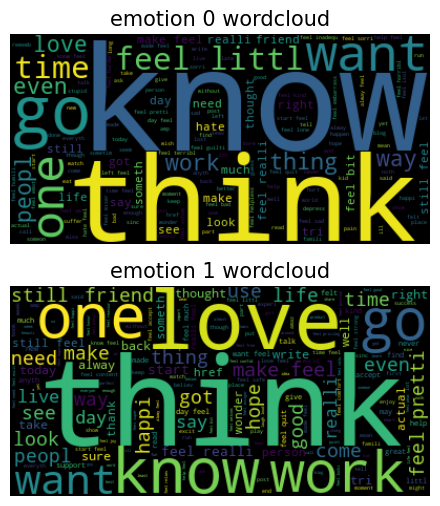

In [309]:
f, axes = plt.subplots(2, 1)
f.set_figheight(6)
f.set_figwidth(12)

for i, ax in enumerate(axes):
    result = full_df.stem_text[full_df.emotion == i]
    
    result = set(result)
    result_text = ' '.join(result)
    wordcloud = WordCloud().generate(result_text)

    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f'emotion {i} wordcloud', fontsize=15)

## Диаграмма распределения классов

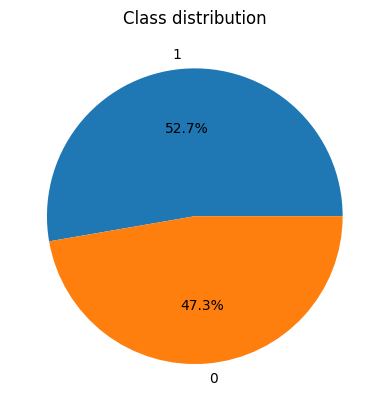

In [310]:
full_df.emotion.value_counts().plot(kind='pie', title='Class distribution', autopct='%1.1f%%')
plt.axis('off')
plt.show()

In [311]:
# примеры текста отрицательных эмоций
for true_value in full_df[full_df.emotion == 0]['text'].head(5):
    print(true_value)

carefully word blog posts amount criticism hear place coming saudis non saudis goes show feeling discontent lot areas directed towards specific people never swat teams charging conversations
think helping also began feel pretty lonely lot people used enjoy climbing moved really feel like anyone climb hard gym anymore
still feeling exhausted know strength gotten day
feeling extremely ugly right
waiting sun come back school called joey sore throat want summer make lunch love alllllllllllll


In [312]:
# примеры текста положительных эмоций
for true_value in full_df[full_df.emotion == 1]['text'].head(5):
    print(true_value)

cannot remember little mermaid feeling carefree beauty life gets lost somewhere massive piles homework budgeting finances eventually daunting choices life become adult
not feeling super well turns cold knocked next three weeks afterward hotter know head not
feel honored part group amazing talents
feel like pleasant nice around
cannot get feelings not trusting head


## Построение модели

### обработка на английском

In [16]:
import sys

In [17]:
sys.path.append('C:\projects\Python\ML_TOOLS')

In [18]:
from models_ml import Classifier

In [316]:
model_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer = lambda x: tokenize_sentence(x))),
    ('model', Classifier(LogisticRegression(random_state = 0)))
])

In [317]:
model_pipeline.fit(x_train, y_train.to_numpy())

c:\interpreter\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x0000025D11BE5B20>)),
                ('model', <models_ml.Classifier object at 0x0000025D345E9DD0>)])

In [318]:
y_pred = model_pipeline.predict(x_test)

In [319]:
model_pipeline['model'].report(y_test, y_pred)

Error calculating ndcg_score: Only ('multilabel-indicator', 'continuous-multioutput', 'multiclass-multioutput') formats are supported. Got binary instead
Error calculating dcg_score: Only ('multilabel-indicator', 'continuous-multioutput', 'multiclass-multioutput') formats are supported. Got binary instead
Error calculating fbeta_score: missing a required argument: 'beta'
Error calculating label_ranking_average_precision_score: binary format is not supported


c:\interpreter\Lib\site-packages\sklearn\metrics\_ranking.py:2025: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(


{'accuracy_score': 0.6078847343763811,
 'precision_score': 0.6155008309412298,
 'recall_score': 0.6829840737636211,
 'f1_score': 0.647488874761602,
 'd2_absolute_error_score': 0.17053103964098726,
 'completeness_score': 0.032634474436507084,
 'homogeneity_score': 0.03201828476200669,
 'jaccard_score': 0.47873090481786135,
 'brier_score_loss': 0.39211526562361887,
 'd2_tweedie_score': -0.5731403769558276,
 'cohen_kappa_score': 0.2084234293249254,
 'd2_pinball_score': 0.17053103964098726,
 'mutual_info_score': 0.022145740894119192,
 'adjusted_mutual_info_score': 0.03226100680473503,
 'average_precision_score': 0.5875300979450897,
 'balanced_accuracy_score': 0.6035526202774725,
 'top_k_accuracy_score': 1.0,
 'roc_auc_score': 0.6035526202774726,
 'gini': 0.20710524055494517}

In [55]:
vectorizer = TfidfVectorizer(tokenizer = lambda x: tokenize_sentence2(x))
vectorizer.fit(x_train)

c:\interpreter\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TfidfVectorizer(tokenizer=<function <lambda> at 0x000001FCAB6D5300>)

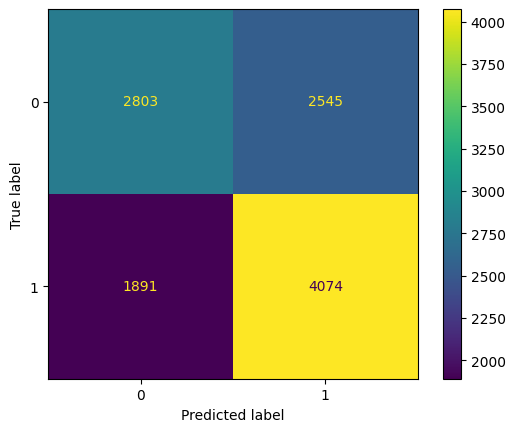

In [332]:
model_pipeline['model'].confusion_matrix_display(vectorizer.transform(x_test), y_test.to_numpy())

In [321]:
probs = model_pipeline.predict_proba(x_test)

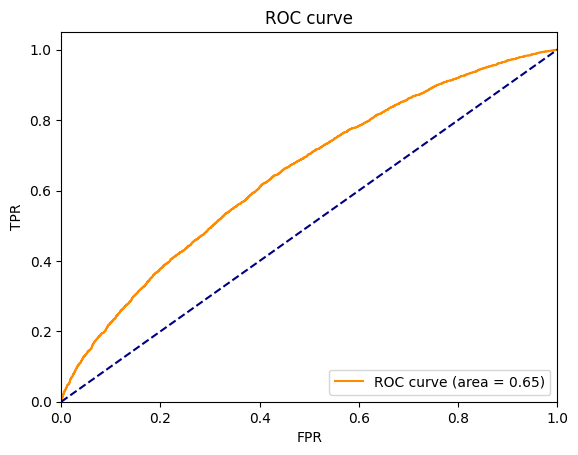

In [322]:
model_pipeline['model'].roc_auc_plot(y_test, probs[:, 1])

In [323]:
model_pipeline.predict(["here me out"])

array([0], dtype=int64)

### обработка на русском

In [53]:
russian_stop_words = stopwords.words('russian')
snowball = SnowballStemmer(language='russian')

def tokenize_sentence2(sentence: str, remove_stop_words: bool = True):
    tokens = word_tokenize(sentence, language = 'russian')
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stop_words:
        tokens = [i for i in tokens if i not in russian_stop_words]
    tokens = [snowball.stem(i) for i in tokens]
    return tokens

In [44]:
model_pipeline2 = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer = lambda x: tokenize_sentence2(x, remove_stop_words=True))),
    ('model', Classifier(LogisticRegression(random_state = 0)))
])

In [46]:
model_pipeline2.fit(x_train, y_train.to_numpy())

c:\interpreter\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x000001FCB1BBB240>)),
                ('model', <models_ml.Classifier object at 0x000001FCA96EC350>)])

In [48]:
y_pred2 = model_pipeline2.predict(x_test)

In [50]:
model_pipeline2['model'].report(y_test, y_pred2)

Error calculating ndcg_score: Only ('multilabel-indicator', 'continuous-multioutput', 'multiclass-multioutput') formats are supported. Got binary instead
Error calculating dcg_score: Only ('multilabel-indicator', 'continuous-multioutput', 'multiclass-multioutput') formats are supported. Got binary instead
Error calculating fbeta_score: missing a required argument: 'beta'
Error calculating label_ranking_average_precision_score: binary format is not supported


c:\interpreter\Lib\site-packages\sklearn\metrics\_ranking.py:2025: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(


{'accuracy_score': 0.9595156015203747,
 'precision_score': 0.9592994161801501,
 'recall_score': 0.9641240569991618,
 'f1_score': 0.961705685618729,
 'd2_absolute_error_score': 0.9143605086013463,
 'completeness_score': 0.7552978030890507,
 'homogeneity_score': 0.7549662132465396,
 'jaccard_score': 0.9262361088742148,
 'brier_score_loss': 0.04048439847962521,
 'd2_tweedie_score': 0.837579284795814,
 'cohen_kappa_score': 0.9187660749793872,
 'd2_pinball_score': 0.9143605086013463,
 'mutual_info_score': 0.5221793193060587,
 'adjusted_mutual_info_score': 0.7551163181980972,
 'average_precision_score': 0.9437999359971969,
 'balanced_accuracy_score': 0.9592497622318172,
 'top_k_accuracy_score': 1.0,
 'roc_auc_score': 0.9592497622318172,
 'gini': 0.9184995244636345}

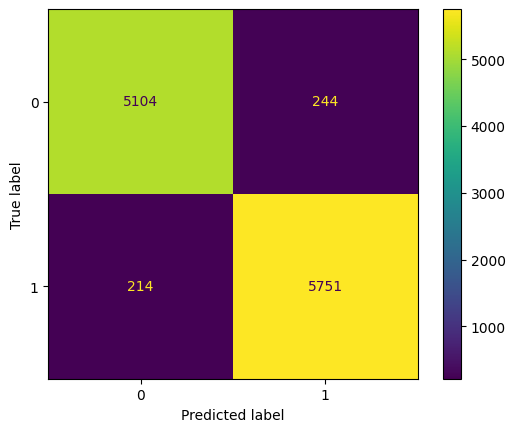

In [56]:
model_pipeline2['model'].confusion_matrix_display(vectorizer.transform(x_test), y_test.to_numpy())

In [60]:
probs = model_pipeline2.predict_proba(x_test)

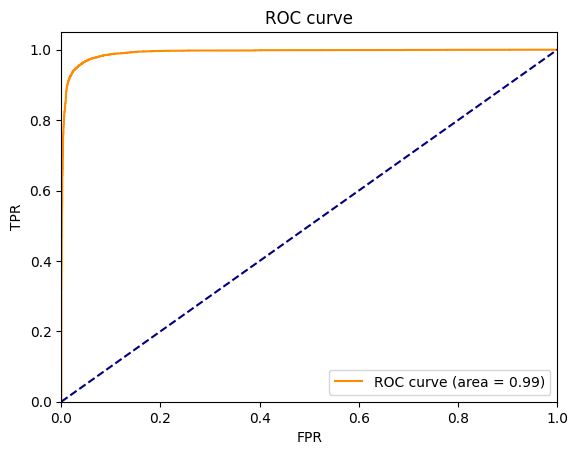

In [61]:
model_pipeline2['model'].roc_auc_plot(y_test, probs[:, 1])